# RLID-NET Validation and Analysis

This notebook analyzes the simulation results to answer several key questions about model performance and strategy.

In [ ]:
import torch

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())

2.7.1+cpu
<function is_available at 0x000001B329DCA200>


In [23]:
import pandas as pd
import numpy as np
import os
import glob
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# --- Constants ---
BASE_DIR = './results'
WEIGHTS = ["w0100", "w1090", "w2080", "w3070", "w4060", "w5050", "w6040", "w7030", "w8020", "w9010", "w1000"]

### 1 & 2. Analysis of Well-Rewarded Proportions

In [3]:
analysis_data = []
total_sims_overall = 0
well_rewarded_overall = 0

for weight in WEIGHTS:
    weight_path = os.path.join(BASE_DIR, weight)
    well_rewarded_path = os.path.join(weight_path, 'well_rewarded')

    try:
        well_rewarded_count = len([name for name in os.listdir(well_rewarded_path) if os.path.isdir(os.path.join(well_rewarded_path, name))])
    except FileNotFoundError:
        well_rewarded_count = 0

    try:
        all_items = os.listdir(weight_path)
        all_dirs = [d for d in all_items if os.path.isdir(os.path.join(weight_path, d))]
        non_well_rewarded_count = len(all_dirs) - 1 if 'well_rewarded' in all_dirs else len(all_dirs)
        non_well_rewarded_count = max(0, non_well_rewarded_count)
    except FileNotFoundError:
        non_well_rewarded_count = 0

    total_sim_count = non_well_rewarded_count + well_rewarded_count
    percentage = (well_rewarded_count / total_sim_count * 100) if total_sim_count > 0 else 0

    analysis_data.append({
        'Weight': weight,
        'Total Simulations': total_sim_count,
        'Well-Rewarded': well_rewarded_count,
        'Percentage (%)': percentage
    })

    total_sims_overall += total_sim_count
    well_rewarded_overall += well_rewarded_count

display(Markdown('#### 1. Well-Rewarded Proportion by Weight'))
results_df = pd.DataFrame(analysis_data)
display(results_df.style.format({'Percentage (%)': '{:.1f}%'}))

overall_percentage = (well_rewarded_overall / total_sims_overall * 100) if total_sims_overall > 0 else 0
display(Markdown('#### 2. Overall Well-Rewarded Proportion'))
print(f'Total Simulations: {total_sims_overall}')
print(f'Total Well-Rewarded: {well_rewarded_overall}')
print(f'Overall Percentage: {overall_percentage:.1f}%')

#### 1. Well-Rewarded Proportion by Weight

#### 2. Overall Well-Rewarded Proportion

Total Simulations: 469
Total Well-Rewarded: 129
Overall Percentage: 27.5%


### 3 & 4. Learning Stabilization Analysis

In [4]:
def find_stabilization_episode(metric_file_path, window=30, threshold_pct=0.05):
    try:
        df = pd.read_excel(metric_file_path)
        if 'Reward' not in df.columns or len(df) < window:
            return None
        last_10_pct_index = int(len(df) * 0.9)
        target_reward = df['Reward'].iloc[last_10_pct_index:].mean()
        moving_avg = df['Reward'].rolling(window=window).mean()
        threshold_value = target_reward * threshold_pct
        stable_episodes = moving_avg[abs(moving_avg - target_reward) <= threshold_value]
        return stable_episodes.index[0] if not stable_episodes.empty else None
    except Exception:
        return None

stabilization_results = []
all_stabilization_episodes = []

for weight in WEIGHTS:
    well_rewarded_pattern = os.path.join(BASE_DIR, weight, 'well_rewarded', '_batch_*')
    well_rewarded_folders = glob.glob(well_rewarded_pattern)
    stabilization_episodes_per_weight = []
    for folder in well_rewarded_folders:
        metric_file = os.path.join(folder, 'training_metrics.xlsx')
        if os.path.exists(metric_file):
            episode = find_stabilization_episode(metric_file)
            if episode is not None:
                stabilization_episodes_per_weight.append(episode)

    avg_episode = np.mean(stabilization_episodes_per_weight) if stabilization_episodes_per_weight else np.nan
    all_stabilization_episodes.extend(stabilization_episodes_per_weight)
    stabilization_results.append({'Weight': weight, 'Avg. Stabilization Episode': avg_episode})

display(Markdown('#### 3. Average Learning Stabilization Episode by Weight'))
stabilization_df = pd.DataFrame(stabilization_results)
display(stabilization_df.style.format({'Avg. Stabilization Episode': '{:.0f}'}))

overall_avg_episode = np.mean(all_stabilization_episodes) if all_stabilization_episodes else np.nan
display(Markdown('#### 4. Overall Average Learning Stabilization Episode'))
print(f'Overall Average Stabilization Episode: {overall_avg_episode:.0f}')

#### 3. Average Learning Stabilization Episode by Weight

#### 4. Overall Average Learning Stabilization Episode

Overall Average Stabilization Episode: 321


### 5 & 6. High-Efficiency LID Usage Analysis

In [5]:
# Per user feedback, top 4 most cost-efficient LIDs are defined as 'high-efficiency'.
HIGH_EFFICIENCY_LIDS = ['Rooftop Disconnection', 'Rain Barrel', 'Green Roof', 'Vegetative Swale']

lid_usage_results = []
overall_total_area = 0
overall_high_efficiency_area = 0

for weight in WEIGHTS:
    well_rewarded_pattern = os.path.join(BASE_DIR, weight, 'well_rewarded', '_batch_*')
    well_rewarded_folders = glob.glob(well_rewarded_pattern)
    total_area_per_weight = 0
    high_efficiency_area_per_weight = 0

    for folder in well_rewarded_folders:
        summary_file = os.path.join(folder, 'lid_placement_summary.xlsx')
        if os.path.exists(summary_file):
            try:
                xls = pd.ExcelFile(summary_file)
                sheet_name = 'LID_Placements' if 'LID_Placements' in xls.sheet_names else xls.sheet_names[0]
                lid_df = pd.read_excel(summary_file, sheet_name=sheet_name)

                area_col = next((col for col in lid_df.columns if 'area' in col.lower()), None)
                lid_type_col = next((col for col in lid_df.columns if 'type' in col.lower()), None)

                if not area_col or not lid_type_col:
                    continue

                lid_df.rename(columns={area_col: 'Area', lid_type_col: 'LID_Type'}, inplace=True)
                lid_df = lid_df[lid_df['LID_Type'] != 'TOTAL']

                total_area = lid_df['Area'].sum()
                high_efficiency_area = lid_df[lid_df['LID_Type'].isin(HIGH_EFFICIENCY_LIDS)]['Area'].sum()

                total_area_per_weight += total_area
                high_efficiency_area_per_weight += high_efficiency_area
            except Exception:
                pass

    percentage = (high_efficiency_area_per_weight / total_area_per_weight * 100) if total_area_per_weight > 0 else 0
    lid_usage_results.append({'Weight': weight, 'High-Efficiency LID Usage (%)': percentage})

    overall_total_area += total_area_per_weight
    overall_high_efficiency_area += high_efficiency_area_per_weight

display(Markdown('#### 5. High-Efficiency LID Usage by Weight'))
lid_usage_df = pd.DataFrame(lid_usage_results)
display(lid_usage_df.style.format({'High-Efficiency LID Usage (%)': '{:.1f}%'}))

overall_lid_usage_percentage = (overall_high_efficiency_area / overall_total_area * 100) if overall_total_area > 0 else 0
display(Markdown('#### 6. Overall High-Efficiency LID Usage'))
print(f'Overall Total LID Area: {overall_total_area:,.0f} m2')
print(f'Overall High-Efficiency LID Area: {overall_high_efficiency_area:,.0f} m2')
print(f'Overall Percentage: {overall_lid_usage_percentage:.1f}%')

#### 5. High-Efficiency LID Usage by Weight

#### 6. Overall High-Efficiency LID Usage

Overall Total LID Area: 8,253,750 m2
Overall High-Efficiency LID Area: 6,456,750 m2
Overall Percentage: 78.2%


### 7. Training Progression of a Single Data Point

=== Training Progression Analysis ===


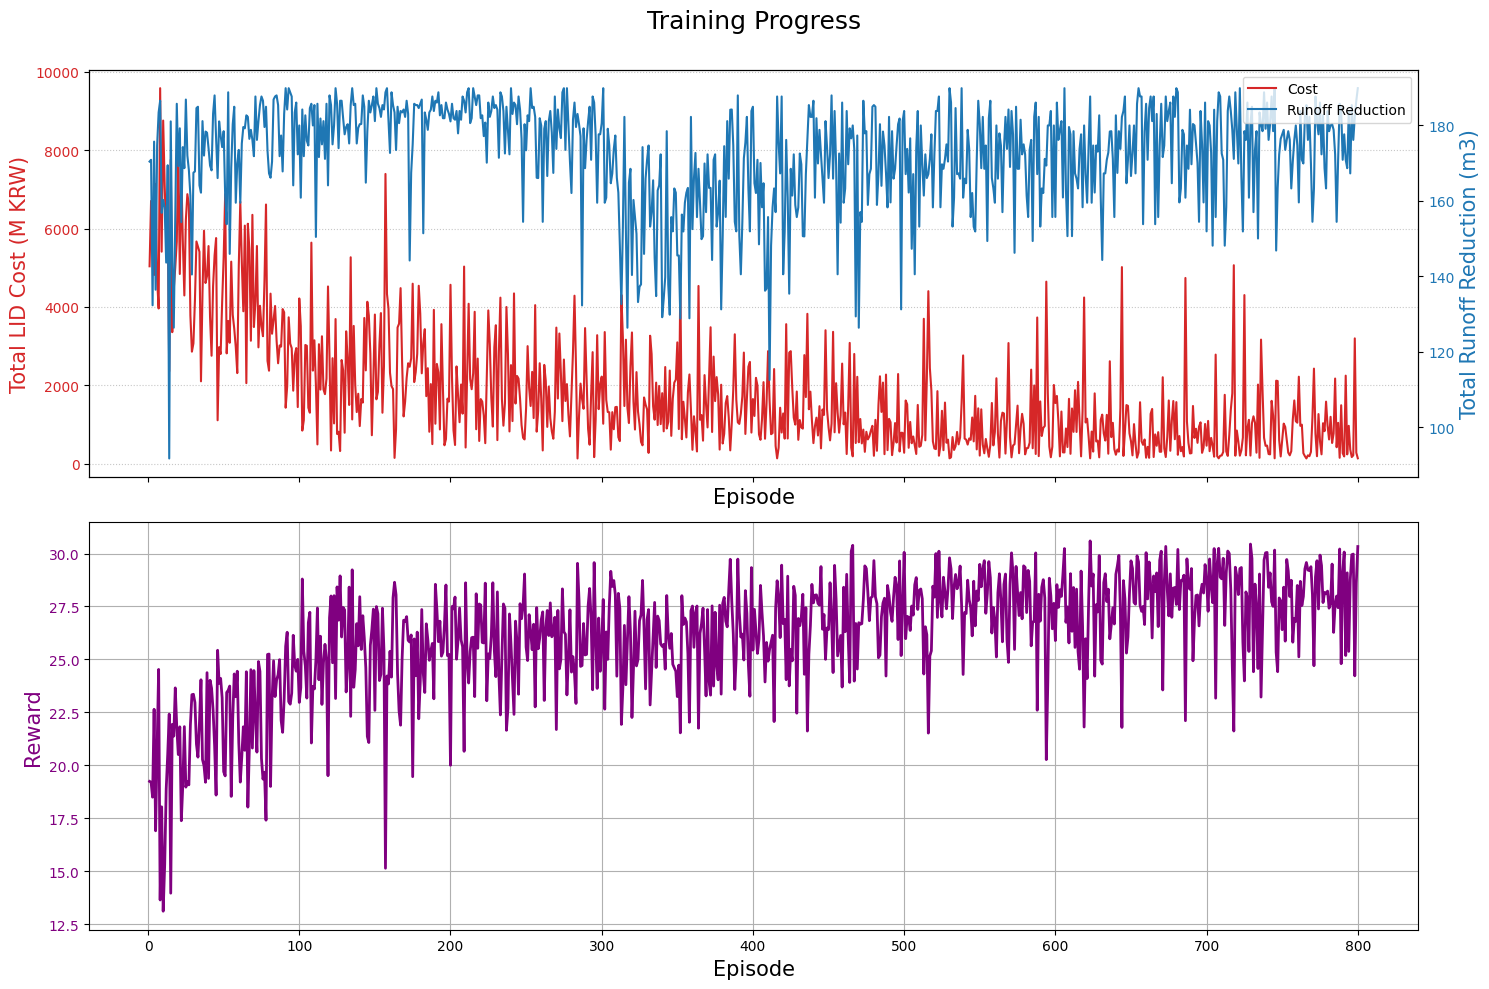

In [6]:
print('=== Training Progression Analysis ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'w5050', 'well_rewarded', '_batch_800_50_20250822_165803w5050_seed4_8lids_newcosts_643216')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    # Create a dual-axis plot
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    # fig.suptitle('Training Progress', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    #ax3.set_title('Reward over Episode', fontsize=16)

    # Title and Legend
    plt.title('Training Progress', fontsize=18, pad=30)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (Performance Point) ===


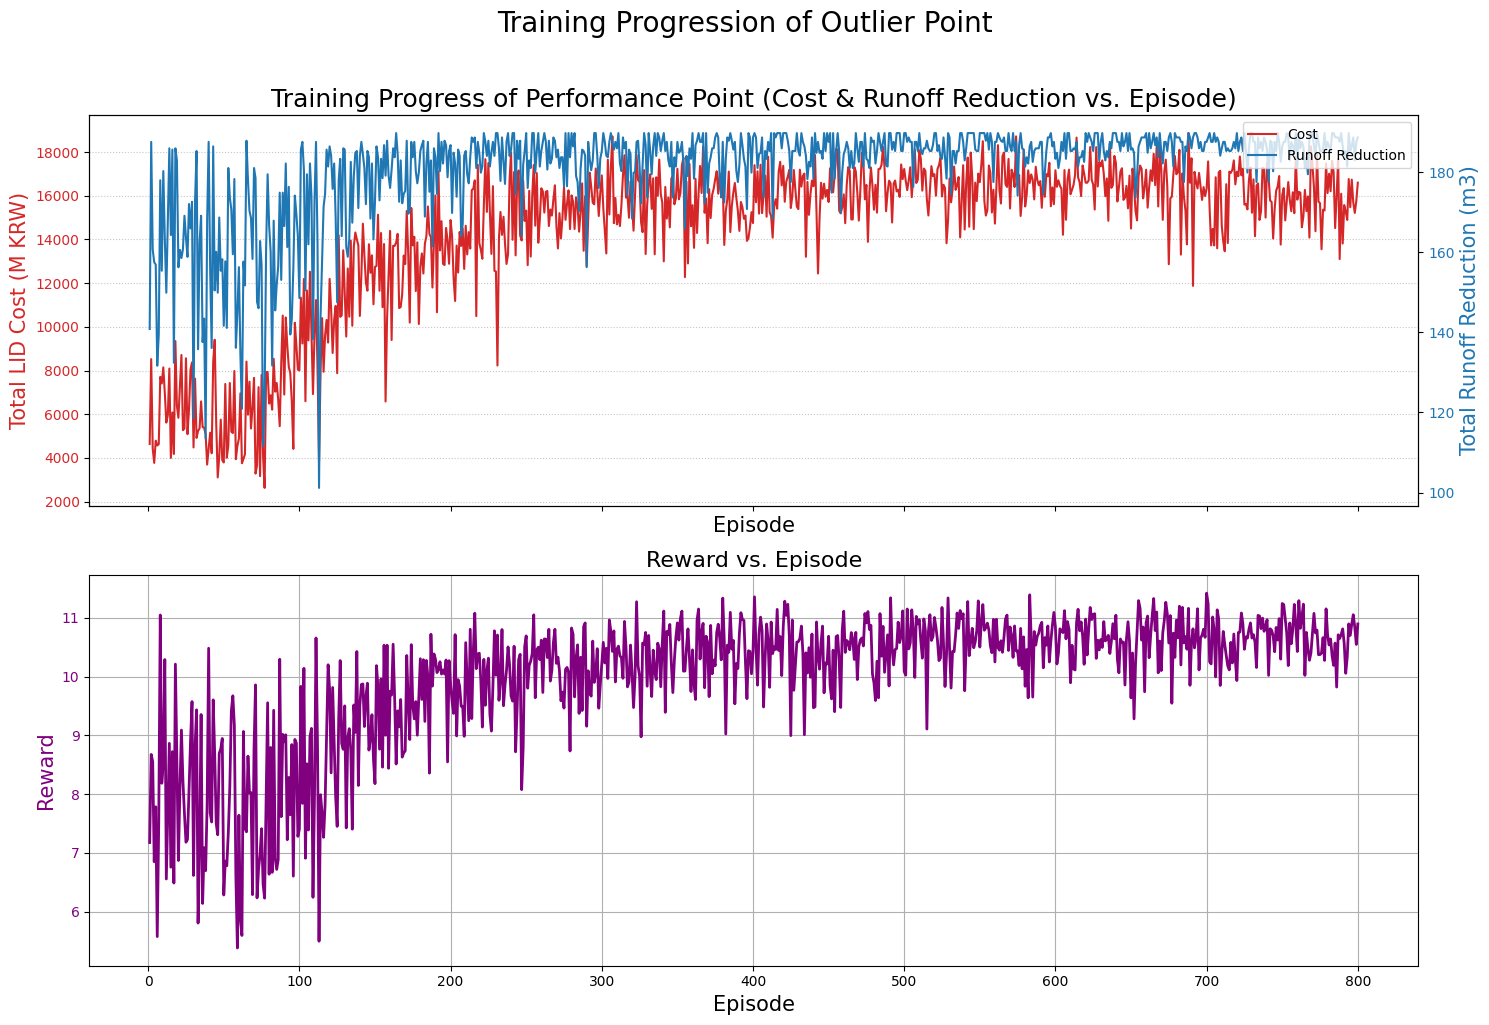

In [7]:
print('=== Training Progression Analysis (Performance Point) ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'w1000', 'well_rewarded', '_batch_800_50_20251002_190041w1000_seed9_8lids_newcosts_643216')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    # Create a dual-axis plot
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)

    # Title and Legend
    plt.title('Training Progress of Performance Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (Cost Point) ===


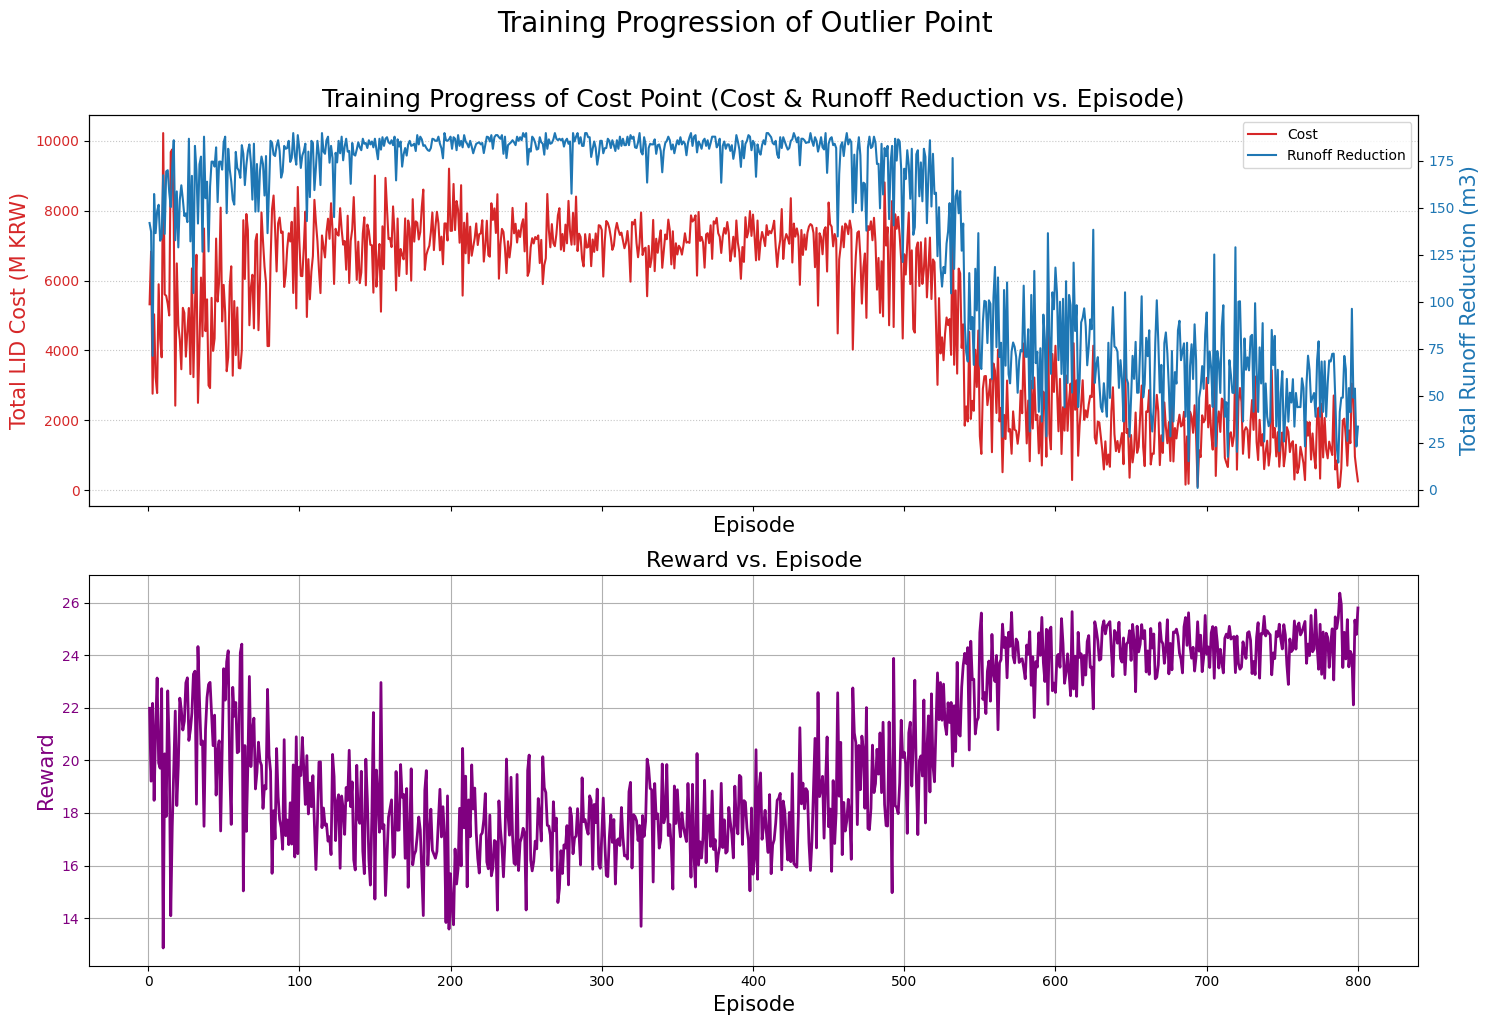

In [8]:
print('=== Training Progression Analysis (Cost Point) ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'w5050', 'well_rewarded', '_batch_800_50_20250822_195157w5050_seed8_8lids_newcosts_643216')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)

    # Title and Legend
    plt.title('Training Progress of Cost Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (w0100) ===


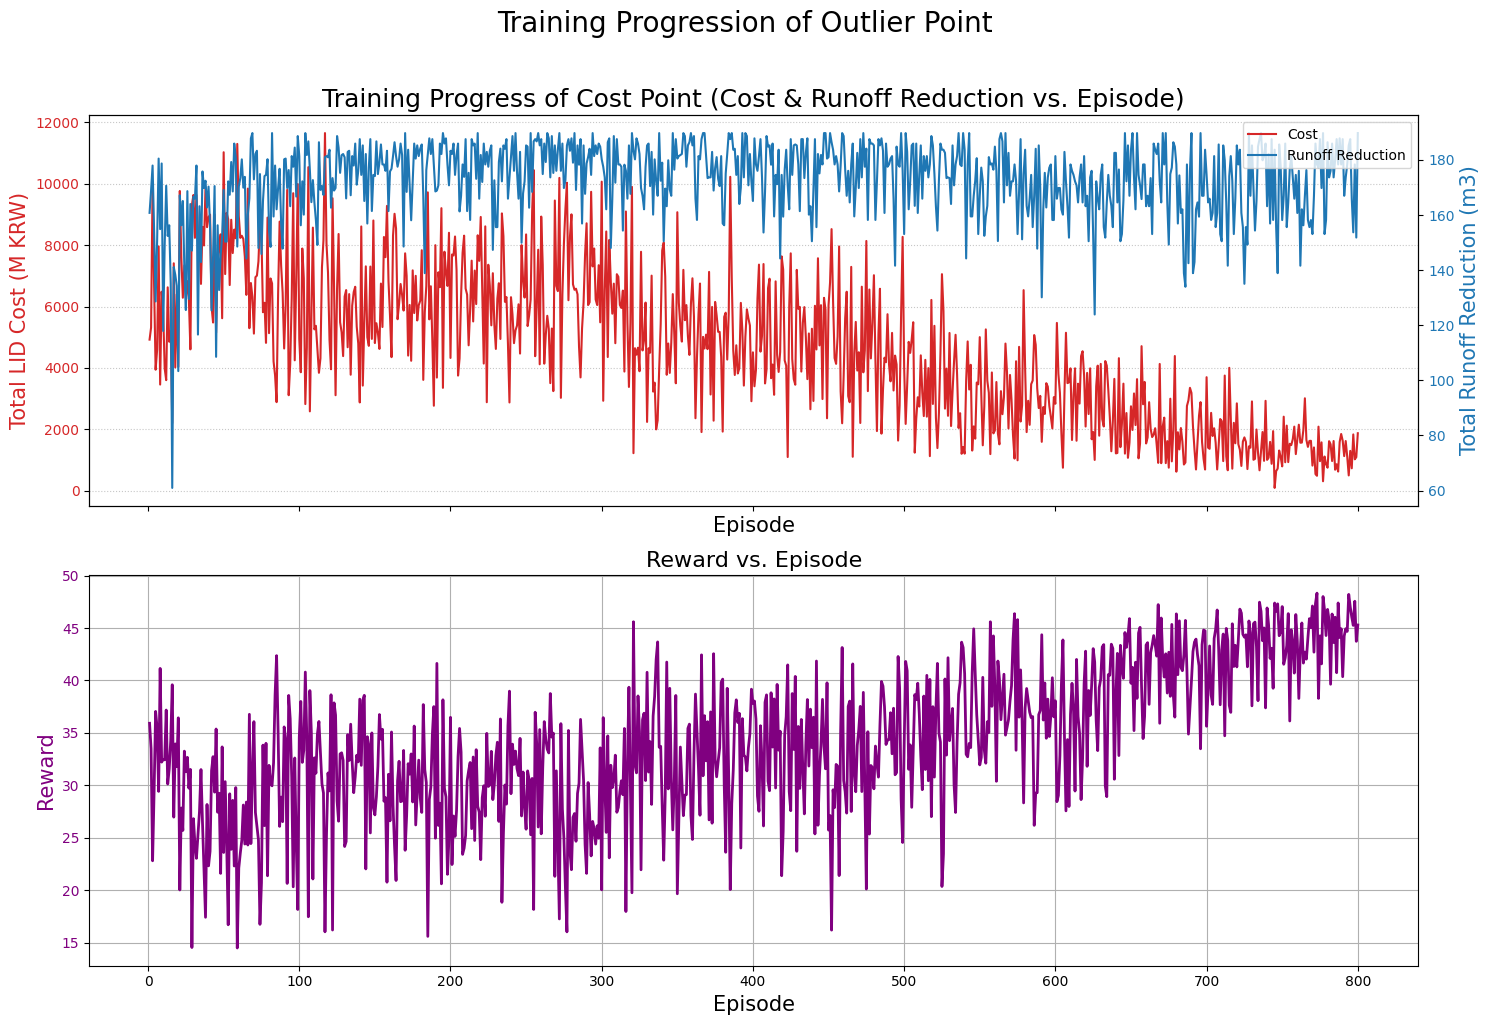

In [9]:
print('=== Training Progression Analysis (w0100) ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'w0100', 'well_rewarded', '_batch_800_50_20251001_044731w0100_seed5_8lids_newcosts_643216')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)

    # Title and Legend
    plt.title('Training Progress of Cost Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (w1090) ===


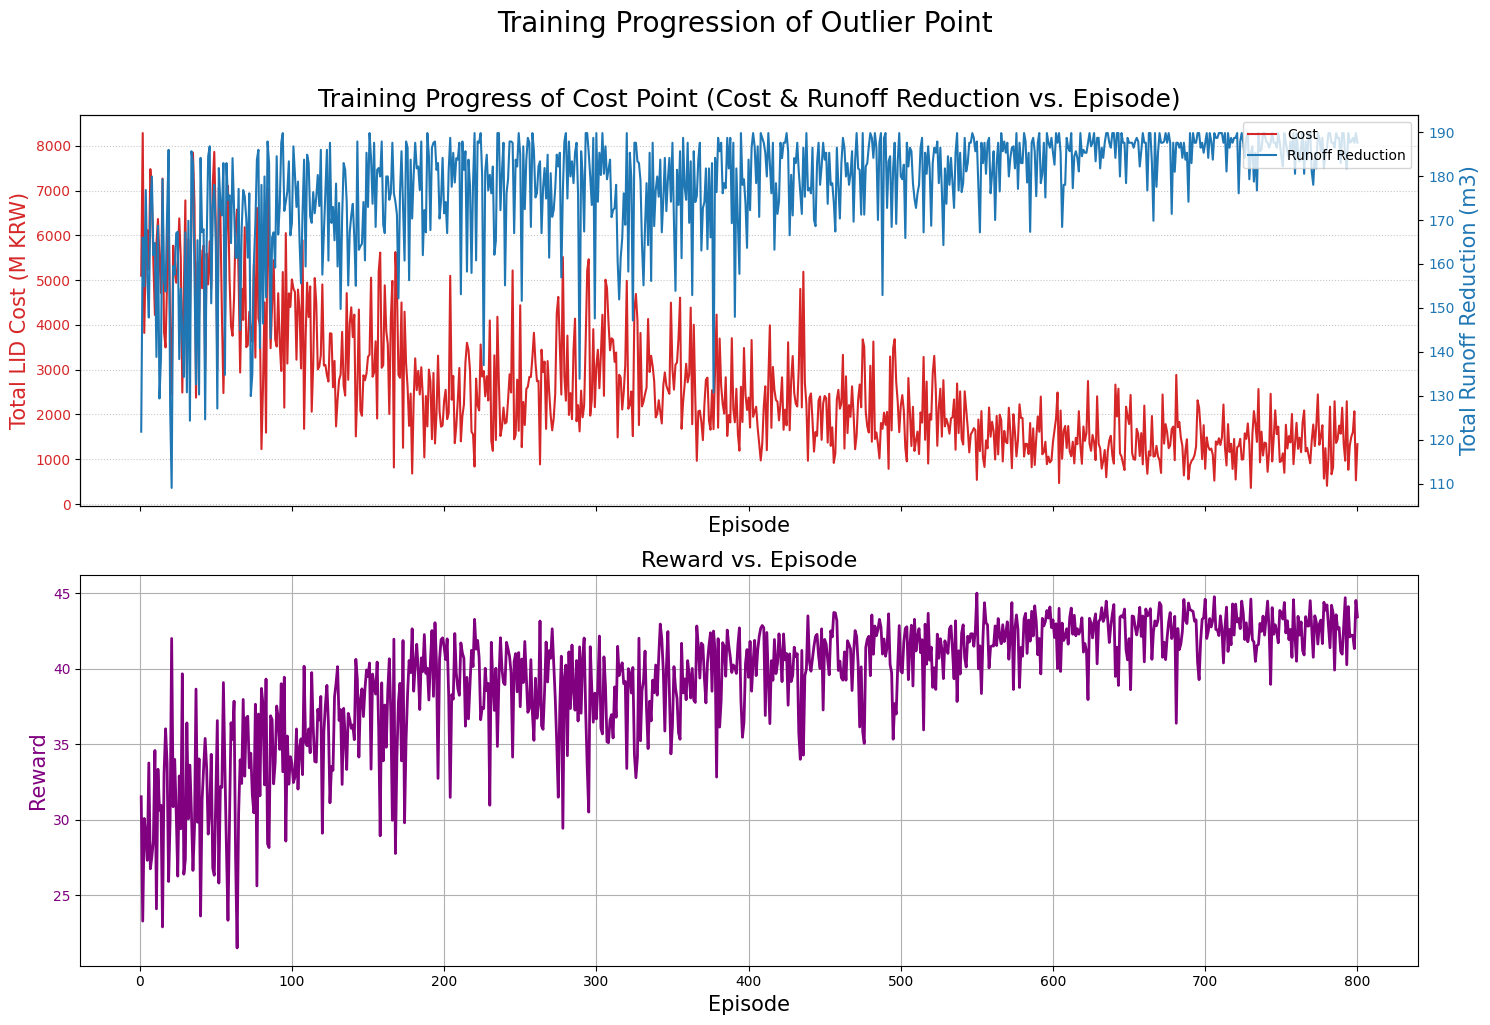

In [10]:
print('=== Training Progression Analysis (w1090) ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'w1090', 'well_rewarded', '_batch_800_50_20250913_055311w1090_seed3_8lids_newcosts_643216')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)
    
    # Title and Legend
    plt.title('Training Progress of Cost Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (w2080) ===


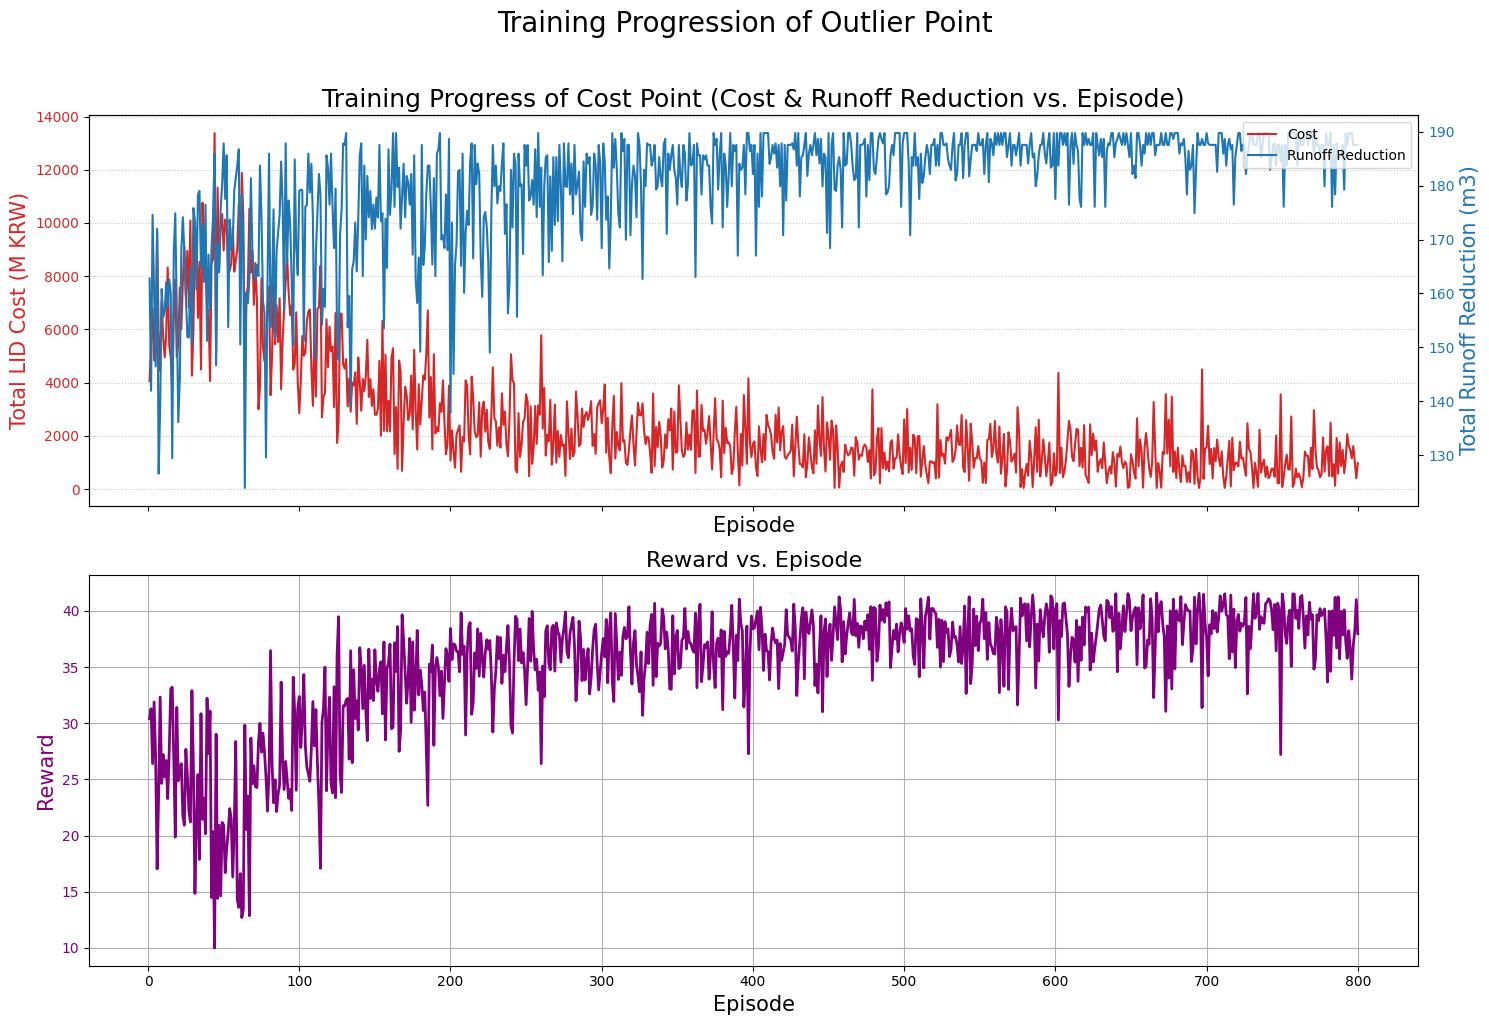

In [11]:
print('=== Training Progression Analysis (w2080) ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'w2080', 'well_rewarded', '_batch_800_50_20250911_121753w2080_seed3_8lids_newcosts_643216')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)
    

    # Title and Legend
    plt.title('Training Progress of Cost Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (w1000) ===


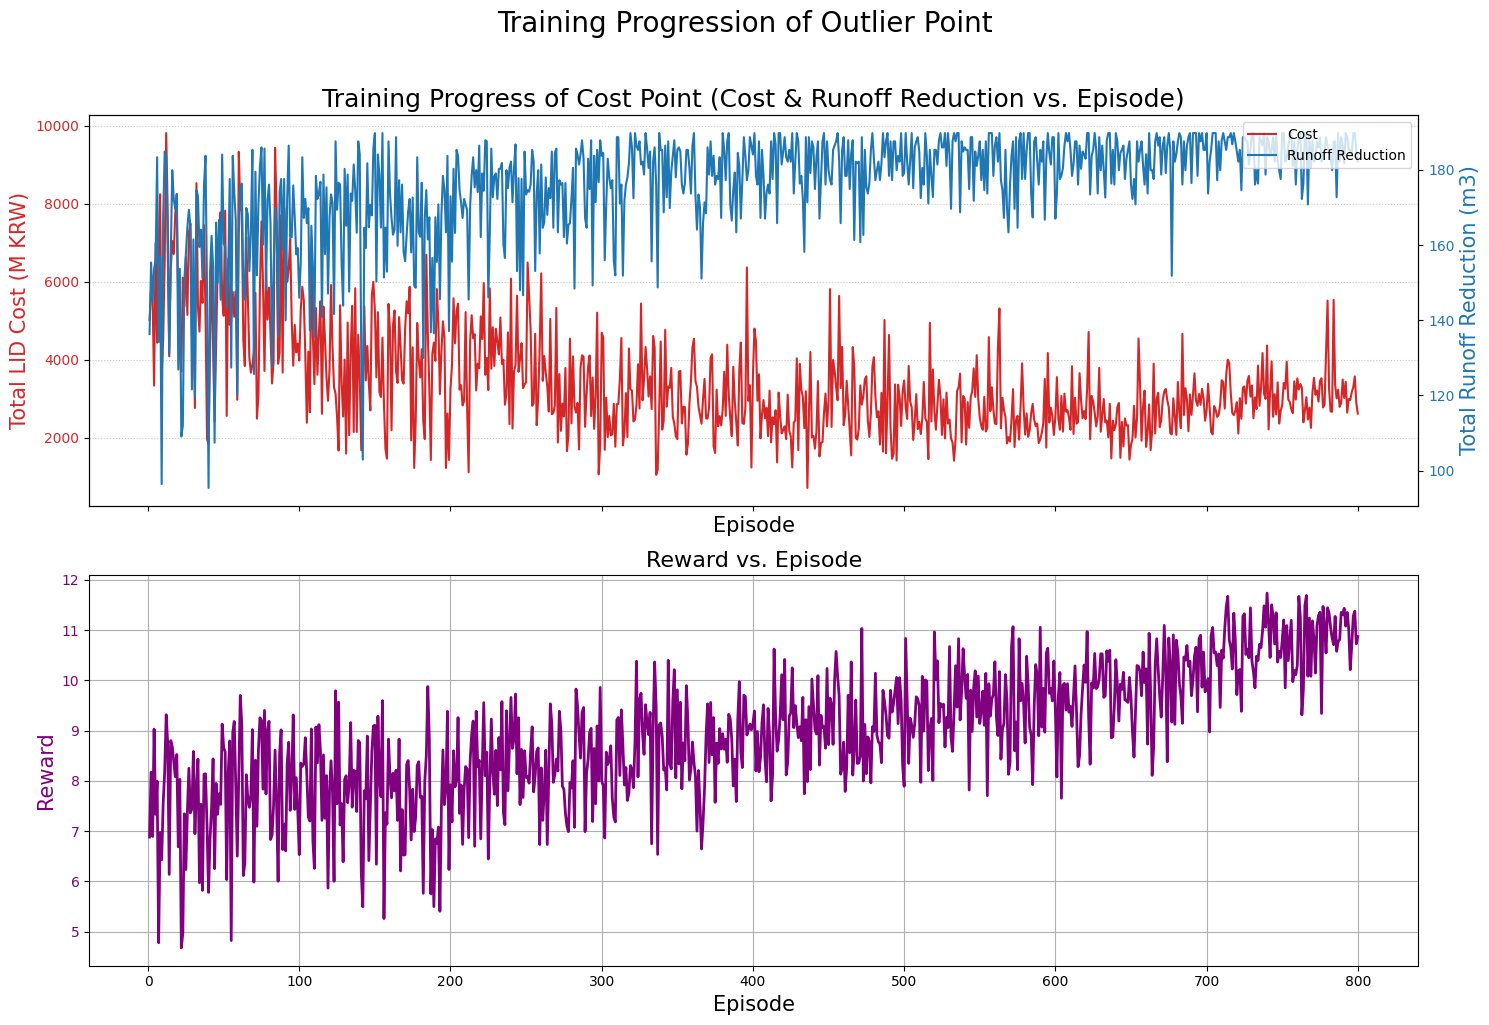

In [12]:

print('=== Training Progression Analysis (w1000) ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'w1000', 'well_rewarded', '_batch_800_50_20250930_184425w1000_seed1_8lids_newcosts_643216')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)
    

    # Title and Legend
    plt.title('Training Progress of Cost Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (w100100) ===


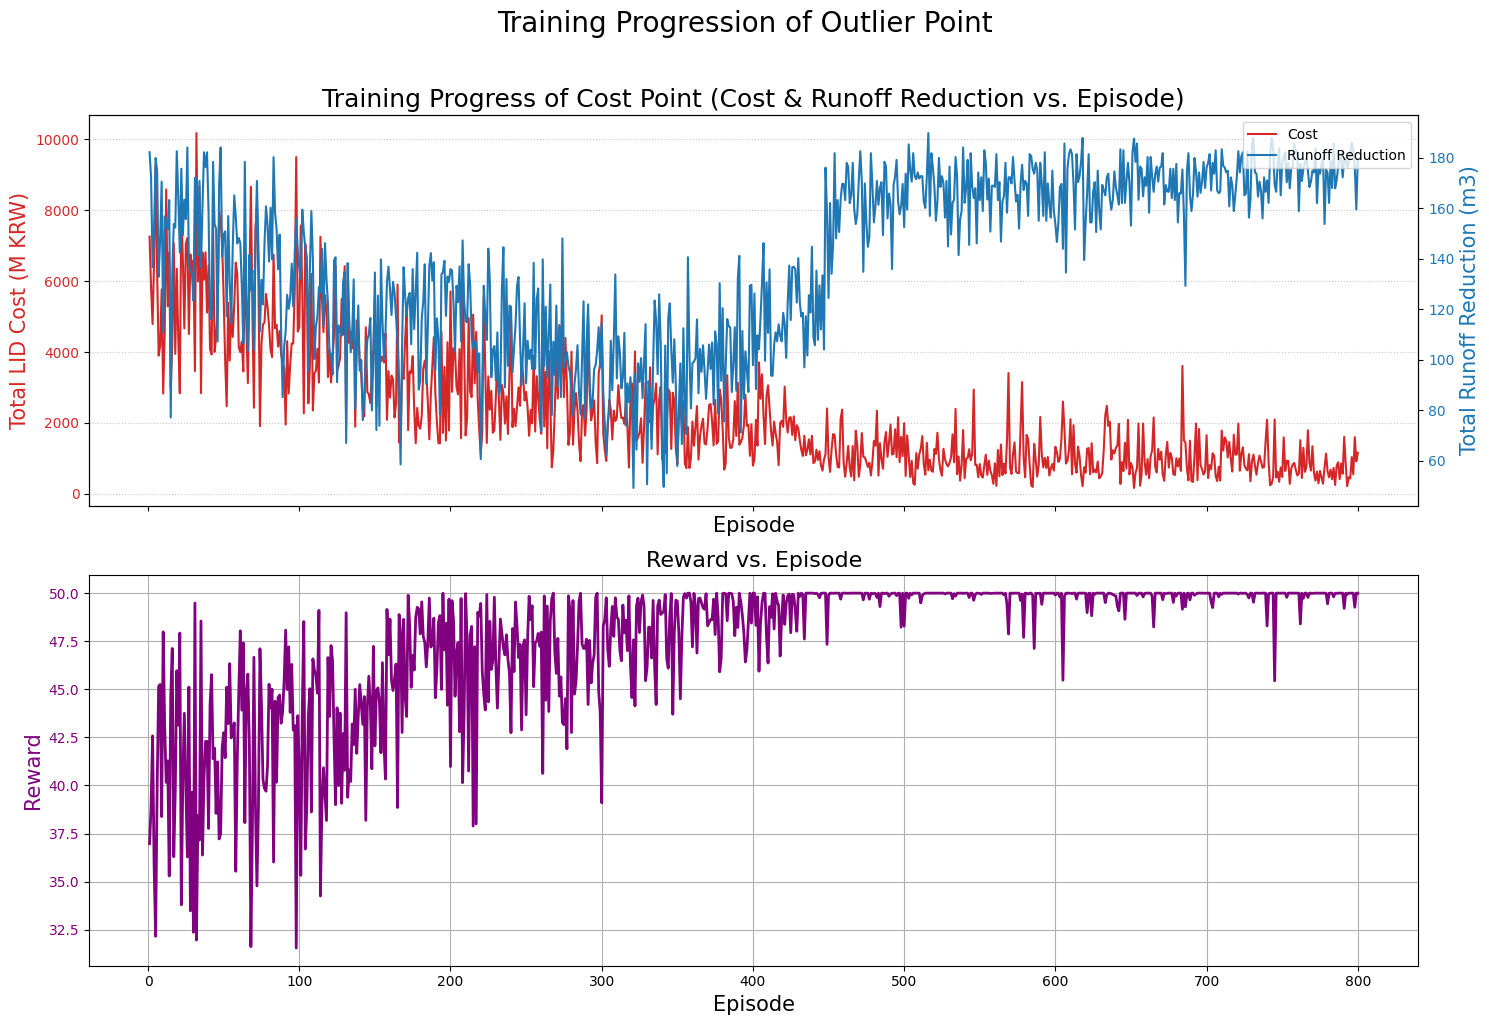

In [13]:

print('=== Training Progression Analysis (w100100) ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'w100100', 'well_rewarded', '_batch_800_50_20251024_045827_seed5_8lids_newcosts_643216')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)
    

    # Title and Legend
    plt.title('Training Progress of Cost Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (seocho2dong 2022) ===


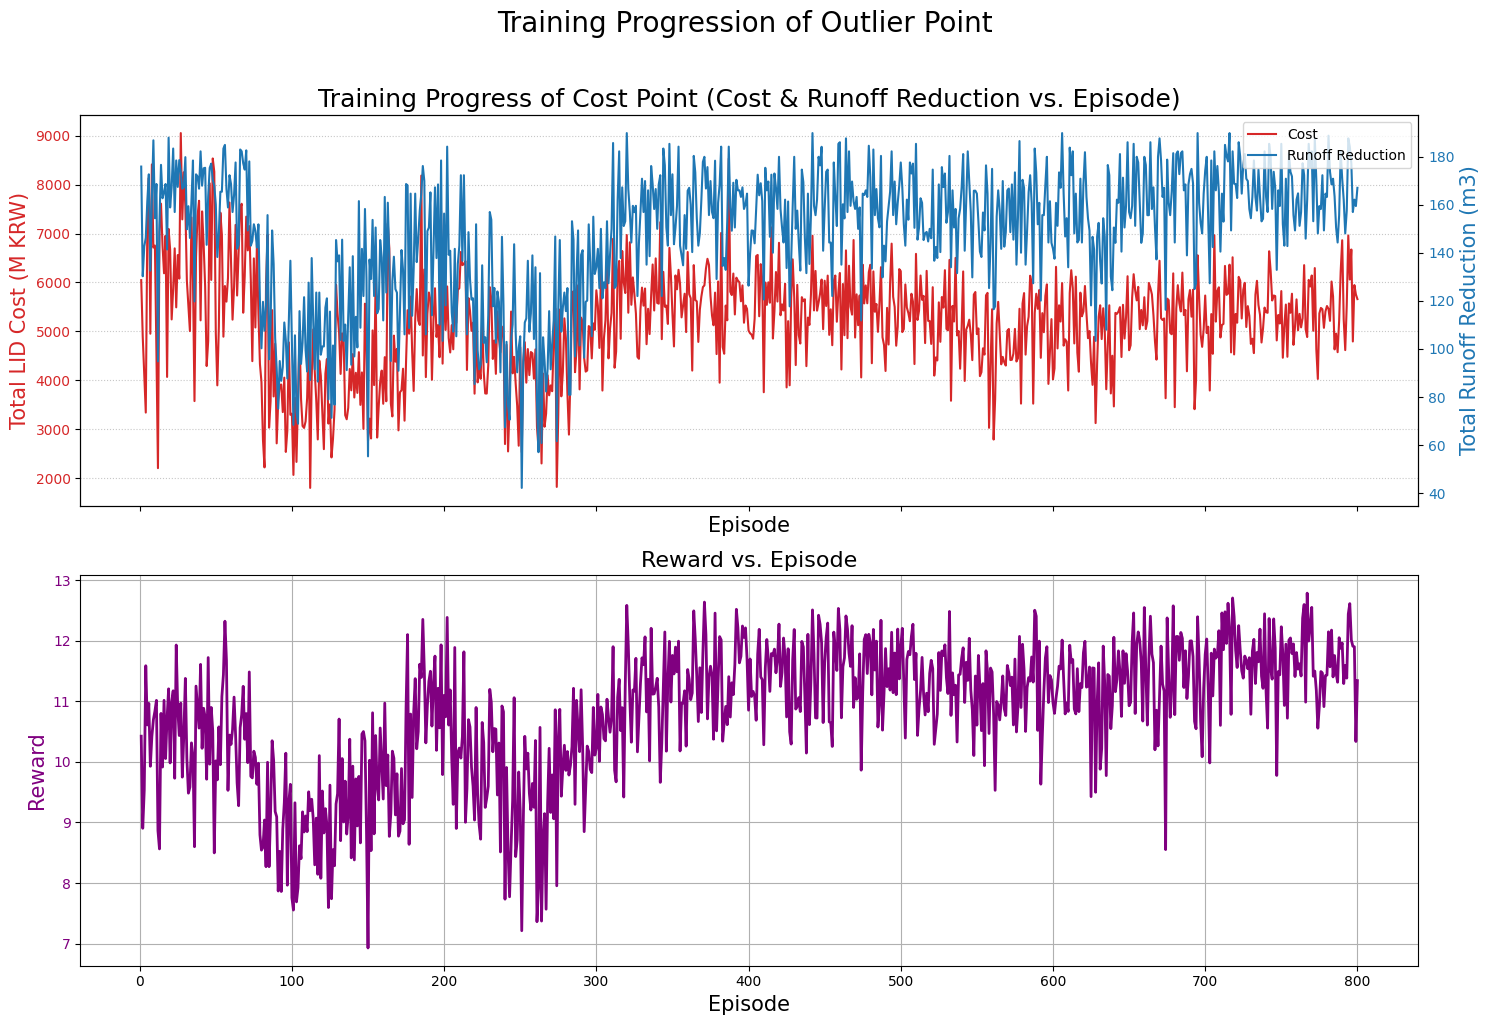

In [14]:

print('=== Training Progression Analysis (seocho2dong 2022) ===')

# Path to the specific data point
outlier_folder_path = os.path.join(BASE_DIR, 'batch_800_50_20251024_090240w9010_seed0_8lids_newcosts_643216_seocho')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)
    

    # Title and Legend
    plt.title('Training Progress of Cost Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

=== Training Progression Analysis (seocho2dong) ===


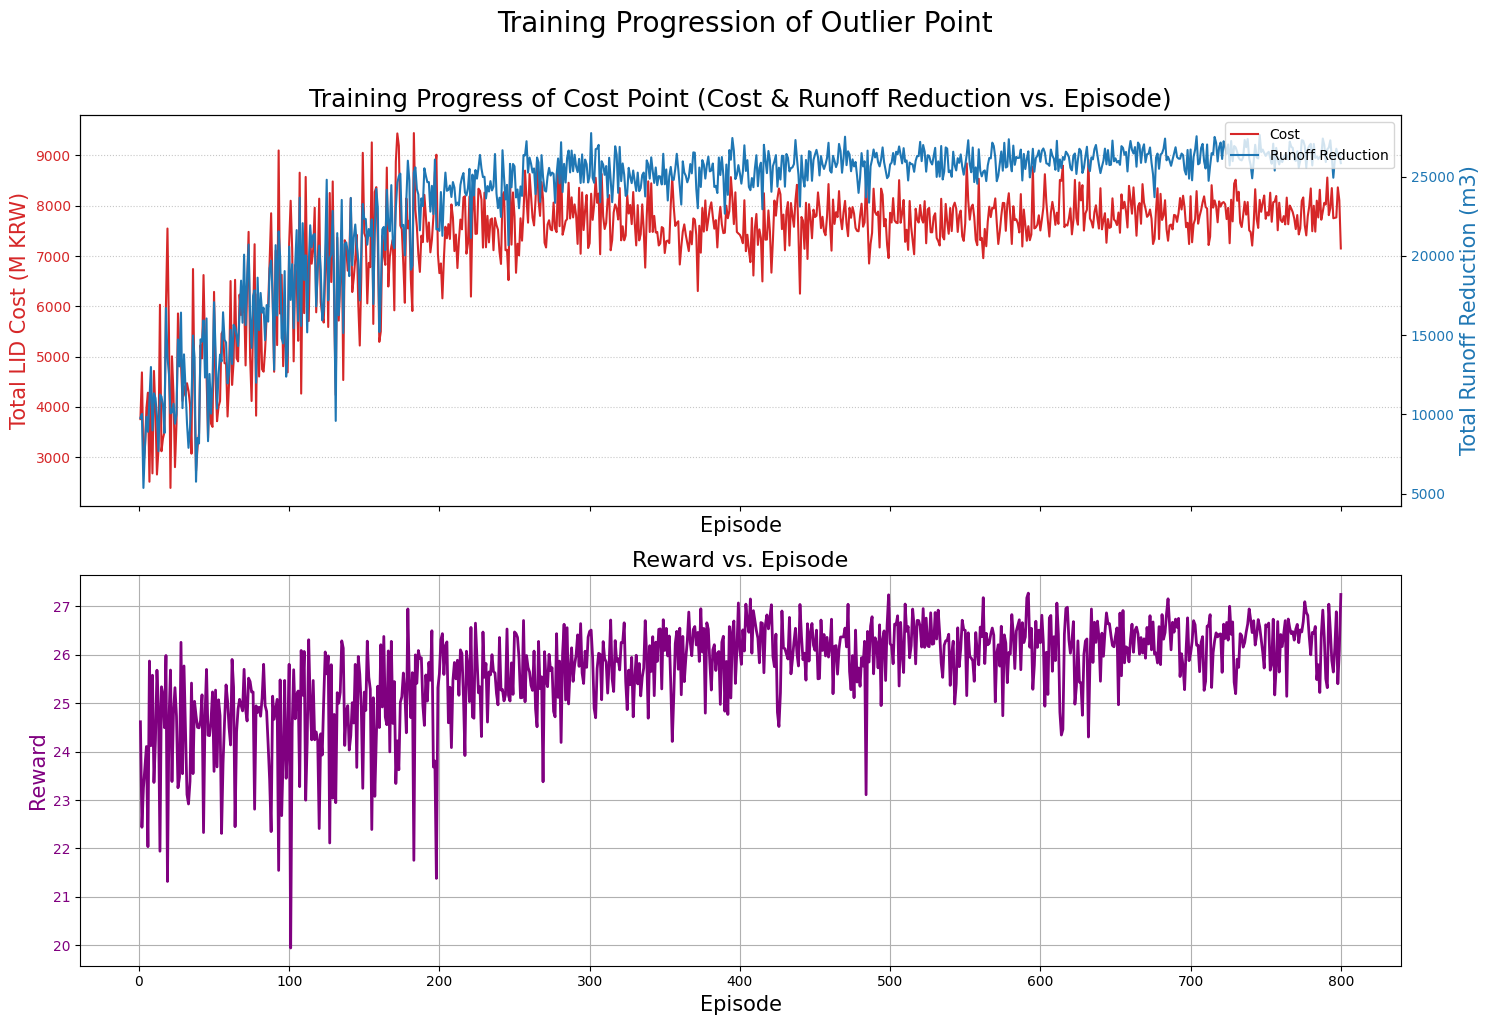

In [ ]:

print('=== Training Progression Analysis (seocho2dong) ===')

# Path to the specific data point
outlier_folder_path = os.path.join('_batch_800_50_20250919_233653w5050_seed0_8lids_newcosts_643216_seocho')
metric_file_path = os.path.join(outlier_folder_path, 'training_metrics.xlsx')

if not os.path.exists(metric_file_path):
    print(f"Error: Metric file not found - {metric_file_path}")
else:
    # Load the training data
    df_progress = pd.read_excel(metric_file_path)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Training Progression of Outlier Point', fontsize=20, y=1.02)

    episodes = df_progress['Episode']

    # Y-axis 1 (Cost)
    color1 = 'tab:red'
    ax1.set_xlabel('Episode', fontsize=15)
    ax1.set_ylabel('Total LID Cost (M KRW)', color=color1, fontsize=15)
    ax1.plot(episodes, df_progress['Total_Cost_KRW'] / 1000000, color=color1, label='Cost')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Y-axis 2 (Runoff Reduction)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Total Runoff Reduction (m3)', color=color2, fontsize=15)
    ax2.plot(episodes, df_progress['Runoff_Reduction_m3'], color=color2, label='Runoff Reduction')
    ax2.tick_params(axis='y', labelcolor=color2)

    color3 = 'purple' # 요청하신 보라색
    ax3.set_xlabel('Episode', fontsize=15)
    ax3.set_ylabel('Reward', color=color3, fontsize=15)
    ax3.plot(episodes, df_progress['Reward'], color=color3, label='Reward', linewidth=2)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.grid(True)
    ax3.set_title('Reward vs. Episode', fontsize=16)
    

    # Title and Legend
    plt.title('Training Progress of Cost Point (Cost & Runoff Reduction vs. Episode)', fontsize=18)
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

In [39]:
def create_training_animation(metrics_file_path, output_gif_path='training_animation.gif'):
    """
    학습 데이터(training_metrics.xlsx)를 기반으로 비용-효과 학습 과정 애니메이션을 생성합니다.
    Args:
    metrics_file_path (str): 분석할 'training_metrics.xlsx' 파일의 전체 경로.
    output_gif_path (str): 저장할 GIF 파일의 이름 또는 경로.
       """
    try:
        df_anim = pd.read_excel(metrics_file_path)
        print(f"'{metrics_file_path}'에서 데이터를 성공적으로 로드했습니다.")
        # 비용 단위를 M KRW로 변환
        df_anim['Cost_M_KRW'] = df_anim['Total_Cost_KRW'] / 1000000
        # 애니메이션 설정
        fig, ax = plt.subplots(figsize=(10, 7))
        # 축 범위 고정
        x_min, x_max = df_anim['Cost_M_KRW'].min(), df_anim['Cost_M_KRW'].max()
        y_min, y_max = df_anim['Runoff_Reduction_m3'].min(), df_anim['Runoff_Reduction_m3'].max()
        ax.set_xlim(x_min - (x_max-x_min)*0.05, x_max + (x_max-x_min)*0.05)
        ax.set_ylim(y_min - (y_max-y_min)*0.05, y_max + (y_max-y_min)*0.05)
        ax.set_xlabel('Total LID Cost (M KRW)')
        ax.set_ylabel('Runoff Reduction (m³)')
        history_scatter = ax.scatter([], [], c='black', alpha=0.4, s=30, label='Past Episodes')
        current_scatter = ax.scatter([], [], c='red', s=120, label='Current Episode', edgecolors='black')
        title = ax.set_title('Episode 0')
        ax.legend(loc='lower right')
        # 애니메이션 업데이트 함수
        def update(episode):
            previous_data = df_anim[df_anim['Episode'] < episode]
            current_data = df_anim[df_anim['Episode'] == episode]
            if not previous_data.empty:
                history_scatter.set_offsets(previous_data[['Cost_M_KRW', 'Runoff_Reduction_m3']].values)
            if not current_data.empty:
                current_scatter.set_offsets(current_data[['Cost_M_KRW', 'Runoff_Reduction_m3']].values)
            title.set_text(f'Episode {episode}')
            return (history_scatter, current_scatter, title)
        # 애니메이션 생성
        num_episodes = df_anim['Episode'].max()
        anim = FuncAnimation(fig, update, frames=range(1, num_episodes + 20, 4), interval=10, blit=False)
        # GIF 파일로 저장
        print(f"애니메이션을 '{output_gif_path}' 파일로 저장 중입니다. 다소 시간이 걸릴 수 있습니다...")
        anim.save(output_gif_path, writer='pillow', fps=20)
        print(f"✅ 성공: 애니메이션이 '{output_gif_path}' 파일로 저장되었습니다.")
        # --- 마지막 프레임 저장 기능 추가 ---
        last_frame_path = output_gif_path.replace('.gif', '_last_frame.png')
        try:
            print(f"애니메이션의 마지막 프레임을 '{last_frame_path}' 파일로 저장 중입니다...")
            # 그래프 상태를 마지막 에피소드로 확실하게 업데이트
            update(num_episodes)
            # 현재 Figure를 고해상도 이미지로 저장
            fig.savefig(last_frame_path, bbox_inches='tight', dpi=300)
            print(f"✅ 성공: 마지막 프레임이 '{last_frame_path}' 파일로 저장되었습니다.")
        except Exception as e:
            print(f"❌ 오류: 마지막 프레임 저장 중 문제가 발생했습니다 - {e}")
        # --- 추가된 부분 끝 ---
        
        plt.close(fig) # 메모리에서 figure를 닫아줍니다.
    except FileNotFoundError:
        print(f"❌ 오류: 파일을 찾을 수 없습니다 - {metrics_file_path}")
    except KeyError as e:
        print(f"❌ 오류: 데이터 파일에서 다음 항목(column)을 찾을 수 없습니다 - {e}. 항목 이름을확인해주세요.")
    except Exception as e:
        print(f"❌ 오류: 애니메이션 생성 중 문제가 발생했습니다 - {e}")

In [40]:
# Example1 최고 효율 점 ./results\w5050\well_rewarded\_batch_800_50_20250822_165803w5050_seed4_8lids_newcosts_643216\lid_placement_summary.xlsx
target_file_path ='./results/w5050/well_rewarded/_batch_800_50_20250822_165803w5050_seed4_8lids_newcosts_643216/training_metrics.xlsx'
output_filename = 'w5050_seed4_animation_fast.gif'
create_training_animation(target_file_path, output_filename)

'./results/w5050/well_rewarded/_batch_800_50_20250822_165803w5050_seed4_8lids_newcosts_643216/training_metrics.xlsx'에서 데이터를 성공적으로 로드했습니다.
애니메이션을 'w5050_seed4_animation_fast.gif' 파일로 저장 중입니다. 다소 시간이 걸릴 수 있습니다...
✅ 성공: 애니메이션이 'w5050_seed4_animation_fast.gif' 파일로 저장되었습니다.
애니메이션의 마지막 프레임을 'w5050_seed4_animation_fast_last_frame.png' 파일로 저장 중입니다...
✅ 성공: 마지막 프레임이 'w5050_seed4_animation_fast_last_frame.png' 파일로 저장되었습니다.


In [30]:
# Example1 최고 유출저감 점
target_file_path ='./results/w1000/well_rewarded/_batch_800_50_20251002_190041w1000_seed9_8lids_newcosts_643216/training_metrics.xlsx'
output_filename = 'w1000_seed9_animation.gif'
create_training_animation(target_file_path, output_filename)

'./results/w1000/well_rewarded/_batch_800_50_20251002_190041w1000_seed9_8lids_newcosts_643216/training_metrics.xlsx'에서 데이터를 성공적으로 로드했습니다.
애니메이션을 'w1000_seed9_animation.gif' 파일로 저장 중입니다. 다소 시간이 걸릴 수 있습니다...
✅ 성공: 애니메이션이 'w1000_seed9_animation.gif' 파일로 저장되었습니다.


In [31]:
# Example1 최저 비용 점
target_file_path ='./results/w5050/well_rewarded/_batch_800_50_20250822_195157w5050_seed8_8lids_newcosts_643216/training_metrics.xlsx'
output_filename = 'lowcost_w5050_seed8_animation.gif'
create_training_animation(target_file_path, output_filename)

'./results/w5050/well_rewarded/_batch_800_50_20250822_195157w5050_seed8_8lids_newcosts_643216/training_metrics.xlsx'에서 데이터를 성공적으로 로드했습니다.
애니메이션을 'lowcost_w5050_seed8_animation.gif' 파일로 저장 중입니다. 다소 시간이 걸릴 수 있습니다...
✅ 성공: 애니메이션이 'lowcost_w5050_seed8_animation.gif' 파일로 저장되었습니다.


In [41]:
# 서초구 최고점
target_file_path ='./_batch_800_50_20250919_233653w5050_seed0_8lids_newcosts_643216_seocho/training_metrics.xlsx'
output_filename = 'seocho2022_w5050_seed0_animation.gif'
create_training_animation(target_file_path, output_filename)

'./_batch_800_50_20250919_233653w5050_seed0_8lids_newcosts_643216_seocho/training_metrics.xlsx'에서 데이터를 성공적으로 로드했습니다.
애니메이션을 'seocho2022_w5050_seed0_animation.gif' 파일로 저장 중입니다. 다소 시간이 걸릴 수 있습니다...
✅ 성공: 애니메이션이 'seocho2022_w5050_seed0_animation.gif' 파일로 저장되었습니다.
애니메이션의 마지막 프레임을 'seocho2022_w5050_seed0_animation_last_frame.png' 파일로 저장 중입니다...
✅ 성공: 마지막 프레임이 'seocho2022_w5050_seed0_animation_last_frame.png' 파일로 저장되었습니다.
